In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 996.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 76.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=830295 sha256=9f32a160a4d232d03e6ae169465ec0fc935712ee78b608fd76377f76d39cae0c
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [2]:
import datetime as dt
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
data = yf.download("AAPL", start="2018-01-01", end=dt.date.today())

[*********************100%***********************]  1 of 1 completed


In [4]:
data["MACD"] = (
    data["Close"].ewm(span=12, adjust=False).mean()
    - data["Close"].ewm(span=26, adjust=False).mean()
)
data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()
data["MACD_diff"] = data["MACD"] - data["Signal_Line"]

window_length = 14
delta = data["Close"].diff(1)
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
data["RSI"] = 100 - (
    100
    / (
        1
        + (up.rolling(window_length).mean() / down.abs().rolling(window_length).mean())
    )
)

data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()
data["SMA_100"] = data["Close"].rolling(window=100).mean()

df = data[["MACD_diff", "RSI", "SMA_20", "SMA_50", "SMA_100", "Close"]].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [5]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : (i + look_back), :-1])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)


look_back = 60  # 60 days input

X, y = create_dataset(df_scaled, look_back)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [6]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(28))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")


In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/100
40/40 [==============================] - 6s 69ms/step - loss: 0.0331 - val_loss: 0.0129
Epoch 2/100
40/40 [==============================] - 2s 48ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 3/100
40/40 [==============================] - 2s 49ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 4/100
40/40 [==============================] - 2s 51ms/step - loss: 9.3962e-04 - val_loss: 0.0101
Epoch 5/100
40/40 [==============================] - 2s 50ms/step - loss: 8.6503e-04 - val_loss: 0.0047
Epoch 6/100
40/40 [==============================] - 2s 51ms/step - loss: 7.2231e-04 - val_loss: 0.0046
Epoch 7/100
40/40 [==============================] - 2s 54ms/step - loss: 7.0161e-04 - val_loss: 0.0022
Epoch 8/100
40/40 [==============================] - 2s 52ms/step - loss: 6.2841e-04 - val_loss: 0.0021
Epoch 9/100
40/40 [==============================] - 2s 49ms/step - loss: 6.1178e-04 - val_loss: 0.0037
Epoch 10/100
40/40 [==============================] - 2s 54ms/step - loss: 5

In [8]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_pred.shape[0], df_scaled.shape[1] - 1)), y_pred), axis=1
    )
)[:, -1]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_test.shape[0], df_scaled.shape[1] - 1)), y_test.reshape(-1, 1)),
        axis=1,
    )
)[:, -1]

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

10/10 [==============================] - 1s 16ms/step
Root Mean Squared Error (RMSE): 4.37


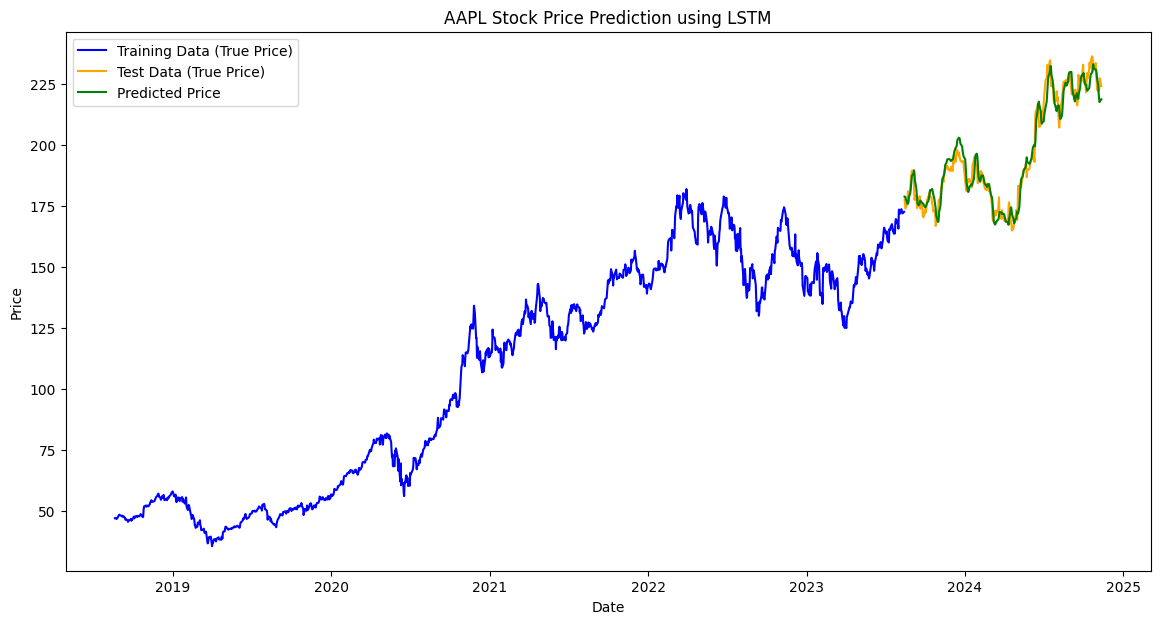

In [9]:
plt.figure(figsize=(14, 7))
dates = df.index[look_back:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

plt.plot(
    train_dates,
    scaler.inverse_transform(df_scaled[:train_size])[:, -1],
    label="Training Data (True Price)",
    color="blue",
)
plt.plot(test_dates, y_test_rescaled, label="Test Data (True Price)", color="orange")
plt.plot(test_dates, y_pred_rescaled, label="Predicted Price", color="green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL Stock Price Prediction using LSTM")
plt.legend()
plt.show()